In [1]:
import os
from STGIC.utils import set_seed
from STGIC.preprocess import *
from STGIC.AGC import *
from STGIC.DCF import *
from STGIC.svg import *
import seaborn as sns
from sklearn.metrics import silhouette_score,davies_bouldin_score

In [2]:
# setup of hyper-parameters, random seed and device for 10x Visium data
n_components_agc=50
n_components=15
use_high_agc=False
use_high=True
agc_dims=26
nChannel=100
output_dim=100

pretrain_lr=0.05
lr=0.01
#lr=0.005
step_kl=0.78
step_con=0.62
step_con1=0.58
step_ce=0.71
q_cut=0.5
mod3_ratio=0.7
seed=0
device=torch.device("cuda:0")

In [3]:
# analysis of the sample 151507 in the benchmark dataset with STGIC
# read the data and generate the input
os.chdir('/home/zhangchen/data/DLPFC')
pid='151507'
h5ad_file = '%s.h5ad' % pid # file name of the sample 151507
img,coord_lattice,mask,adj,feat_agc,adata=generate_input_visium(h5ad_file,n_components_agc,n_components,use_high_agc,use_high) # img: the input of the virtual image for DCF; coord_lattice: lattice_coordinates; mask: used to extract the embeddings of spots from the output of DCF; adj: the original adjacency matrix; feat_agc: the input for AGC pre-clustering; adata: the adata object generated by reading the h5ad file

# extract ground truth label
label=[]
ground_label=list(adata.obs.celltype)
for i in ground_label:
    if i!='nan': # a minuscule amount of spots has no ground truth clustering label
        label.append(i)
    else:
        label.append(-1)
if -1 in label:
    n_clusters = len(set(label)) - 1
else:
    n_clusters = len(set(label))

Run 1: l [0.01, 1000], p [0.0, 312.007390866702]
Run 2: l [0.01, 500.005], p [0.0, 85.49689785188083]
Run 3: l [0.01, 250.0075], p [0.0, 21.6794317771638]
Run 4: l [0.01, 125.00874999999999], p [0.0, 4.808452228205333]
Run 5: l [0.01, 62.509375], p [0.0, 0.5168117477286231]
Run 6: l [31.2596875, 62.509375], p [0.0003445432988955499, 0.5168117477286231]
Run 7: l [46.884531249999995, 62.509375], p [0.0771074195086614, 0.5168117477286231]
Run 8: l [54.69695312499999, 62.509375], p [0.24361312314250982, 0.5168117477286231]
Run 9: l [58.6031640625, 62.509375], p [0.36795887268703864, 0.5168117477286231]
Run 10: l [60.556269531249995, 62.509375], p [0.4395203426554435, 0.5168117477286231]
Run 11: l [61.532822265625, 62.509375], p [0.4774757861254777, 0.5168117477286231]
recommended l =  62.021098632812496


In [4]:
#pre-clustering by AGC
adj_normalized = normalize_adj(adj) # normalization of the adjacency matrix
adj_normalized = 1/3*torch.eye(adj_normalized.shape[0]).to(device)+2/3*adj_normalized #pre-defined graph convolution kernel function
optimal_power,y_pred_init,kmeans_feature,pre_nmi,pre_ari=pre_cluster(adj_normalized,feat_agc,n_clusters,label,top_num=agc_dims,max_iter=30) # the pre-clustering result is obtained through the step. optimal_power: the iteration number for AGC; y_pred_init: cluster assignment as the pre-clustering result generated by AGC; kmeans_feature: the feature vectors of spots for kmeans clustering leading to the pre-clustering result by AGC; pre_nmi: the performance index of nmi displayed by the pre-clustering assignment of clusters; pre_ari: the performance index of ari displayed by the pre-clustering assignment of clusters

In [5]:
# clustering by DCF
coord_x=torch.tensor(coord_lattice[:,0]).to(torch.long).to(device) # abscissa of lattice coordinates
coord_y=torch.tensor(coord_lattice[:,1]).to(torch.long).to(device) # ordinates of lattice coordinates
set_seed(seed)
model3 = Dilate_MyNet5_visium(img.shape[2],output_dim,nChannel,n_clusters,3,2).to(device) # instantiation of the 3*3 framework
model2 = Dilate_MyNet5_visium(img.shape[2],output_dim,nChannel,n_clusters,2,2).to(device) # instantiation of the 2*2 framework
nmi,ari,y_pred_last,emb,final_epoch_idx=dilate2_train5_visium(model3,model2,coord_x,coord_y,n_clusters,step_kl,step_con,step_con1,step_ce,label,img,mask,y_pred_init,200,400,tol=1e-3,update_interval=4,q_cut=q_cut,mod3_ratio=mod3_ratio) # pre-training and training of DCF. nmi: the performance index of nmi displayed by DCF clustering; ari: the performance index of ari displayed by DCF clustering; y_pred_last: the final cluster assignment derived from DCF clustering; emb: spots embeddings generated by DCF; final_epoch_idx: the real iteration number during DCF training

0 0.5108570029691162
1 0.5095303393118406
2 0.507758244793997
3 0.513377770381179
4 0.5167576456375701
5 0.5238959768609689
6 0.5287883125982509
7 0.5282673841962814
8 0.525883202639361
9 0.525502875435752
10 0.5261754835639468
11 0.5258871514435771
12 0.5288322305018145


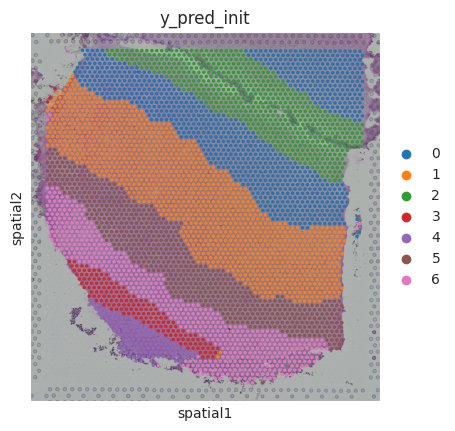

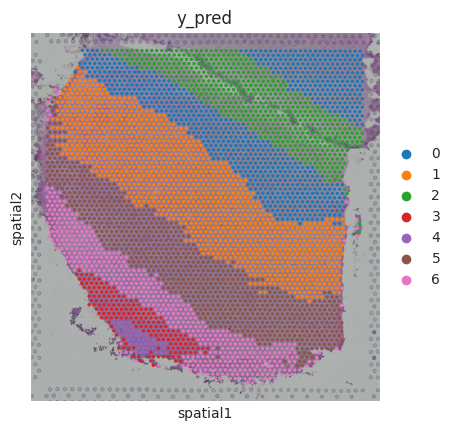

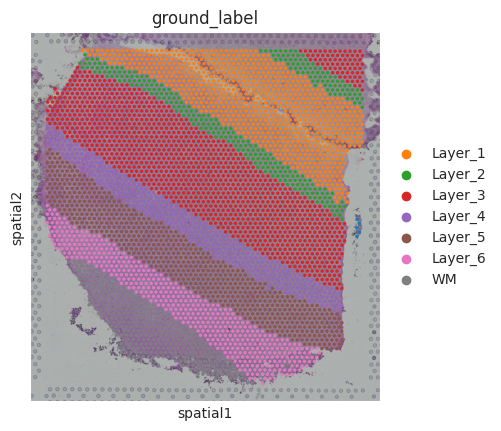

ARI of AGC pre-clustering and DCF clustering on 151507 are respectively 0.5058587343414338 and 0.5288322305018145


In [6]:
# visualization
adata.obs['y_pred']=[str(int(i)) for i in y_pred_last] # saving of labels derived from DCF clustering in adata.obs
adata.obs['y_pred_init']=[str(int(i)) for i in y_pred_init] # saving of labels derived from AGC pre-clustering in adata.obs

adata.obs['ground_label']=[i if i!=-1 else '' for i in label] # saving of ground truth labels in adata.obs


#process to ensure the subsequent spatial domain visualization will be situated in the direction consistent with H&E histological image
adata.obs['x_pixel']=list(adata.obsm['spatial'][:,0])
adata.obs['y_pixel']=list(-adata.obsm['spatial'][:,1])

# spatial domain visualization
sc.pl.spatial(adata,color='y_pred_init') # visualization of spatial domains derived from AGC pre-clustering
sc.pl.spatial(adata,color='y_pred') # visualization of spatial domains derived from DCF clustering
sc.pl.spatial(adata,color='ground_label') # visualization of spatial domains derived from the ground truth

print('ARI of AGC pre-clustering and DCF clustering on %s are respectively %s and %s' %(pid,pre_ari,ari))

In [7]:
print("+++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++")

+++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++


In [8]:
#analysis of human breast cancer 10x Visium data
#read the data and generate input
os.chdir('/home/zhangchen/data')
pid='breast_cancer'
h5ad_file = '%s.h5ad' % pid

img,coord_lattice,mask,adj,feat_agc,adata=generate_input_visium(h5ad_file,n_components_agc,n_components,use_high_agc,use_high)

#extract the annotated labels from Jinmiao Chen's lab
bcl=pd.read_table('/home/zhangchen/validate/metadata.tsv')
bcl.index=bcl.ID
obs1=pd.concat([adata.obs,bcl],1)
bll=obs1.fine_annot_type.values
bl=obs1.fine_annot_type.unique()
n_clusters=len(list(bl))
bl_dic={bl[i]:i for i in range(n_clusters)}
label=[]
for i in bll:
    label.append(bl_dic[i])

Run 1: l [0.01, 1000], p [0.0, 83.64162461302841]
Run 2: l [0.01, 500.005], p [0.0, 21.58456794911748]
Run 3: l [0.01, 250.0075], p [0.0, 4.846828558909231]
Run 4: l [0.01, 125.00874999999999], p [0.0, 0.5336280740092589]
Run 5: l [62.509375, 125.00874999999999], p [0.00040011342567880526, 0.5336280740092589]
Run 6: l [93.7590625, 125.00874999999999], p [0.08206952898578646, 0.5336280740092589]
Run 7: l [109.38390625, 125.00874999999999], p [0.2545152945859672, 0.5336280740092589]
Run 8: l [117.196328125, 125.00874999999999], p [0.38192381225226013, 0.5336280740092589]
Run 9: l [121.1025390625, 125.00874999999999], p [0.4549445241889649, 0.5336280740092589]
recommended l =  123.05564453125


In [9]:
# AGC pre-clustering
adj_normalized = normalize_adj(adj)
adj_normalized = 1/3*torch.eye(adj_normalized.shape[0]).to(device)+2/3*adj_normalized
optimal_power,y_pred_init,kmeans_feature,pre_nmi,pre_ari=pre_cluster(adj_normalized,feat_agc,n_clusters,label,top_num=agc_dims,max_iter=30)


In [10]:
#DCF clustering
coord_x=torch.tensor(coord_lattice[:,0]).to(torch.long).to(device)
coord_y=torch.tensor(coord_lattice[:,1]).to(torch.long).to(device)
set_seed(seed)
model3 = Dilate_MyNet5_visium(img.shape[2],output_dim,nChannel,n_clusters,3,2).to(device)
model2 = Dilate_MyNet5_visium(img.shape[2],output_dim,nChannel,n_clusters,2,2).to(device)
nmi,ari,y_pred_last,emb,final_epoch_idx=dilate2_train5_visium(model3,model2,coord_x,coord_y,n_clusters,step_kl,step_con,step_con1,step_ce,label,img,mask,y_pred_init,200,400,tol=1e-3,update_interval=4,q_cut=q_cut,mod3_ratio=mod3_ratio)

0 0.5597239930940029
1 0.5608186158920958
2 0.5624780445991283
3 0.5641117106461705
4 0.5683703235585758
5 0.5715877438023809
6 0.5729455001003645
7 0.5713173985512221
8 0.5709491591401241
9 0.572423898051026
10 0.5702124131003913
11 0.5736963104423404
12 0.5728144735433438


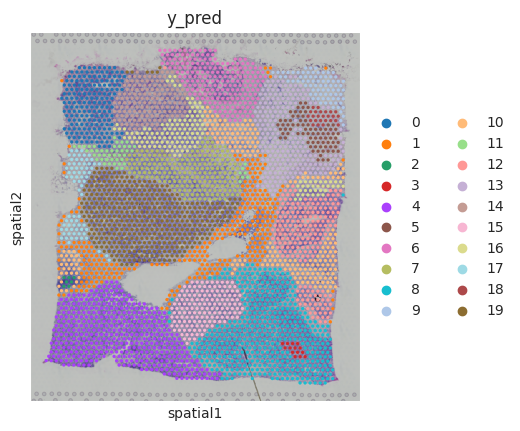

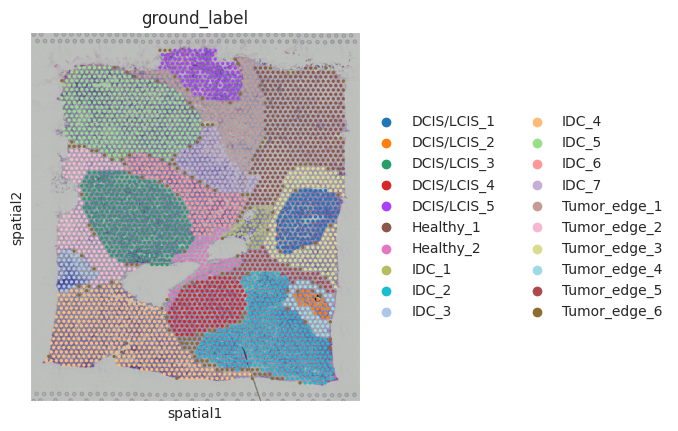

pre-ari on breast cancer 20 clusters by AGC 0.5651225929537284
ari on breast cancer 20 clusters by DCF 0.5728144735433438


In [11]:
# spatial domain visualization
adata.obs['y_pred']=[str(int(i)) for i in y_pred_last]
adata.obs['y_pred_init']=[str(int(i)) for i in y_pred_init]

adata.obs['ground_label']=bll


adata.obs['x_pixel']=list(adata.obsm['spatial'][:,0])
adata.obs['y_pixel']=list(-adata.obsm['spatial'][:,1])
sc.pl.spatial(adata,color='y_pred')
sc.pl.spatial(adata,color='ground_label')
print('pre-ari on breast cancer 20 clusters by AGC',pre_ari)
print('ari on breast cancer 20 clusters by DCF',ari)


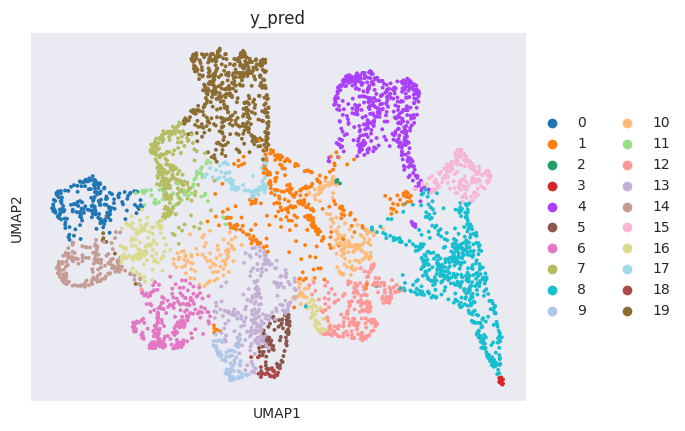

In [12]:
#UMAP visualization
adata.obsm['rep']=emb
sc.pp.neighbors(adata,use_rep='rep',random_state=0)
sc.tl.umap(adata,random_state=0)
sc.pl.umap(adata, color=['y_pred'])

In [13]:
#Moran's I statistics
ground_moran=screen_svg('ground_label',adata) # SVG set identification for computation of moran's I score corresponding to the ground truth labels
stgic_moran=screen_svg('y_pred',adata) # SVG set identification for computation of moran's I score corresponding to the labels generated by DCF
print('ground truth moran statistics mean and median', np.mean(ground_moran),np.median(stgic_moran))
print('STGIC moran statistics mean and median', np.mean(stgic_moran),np.median(stgic_moran))

Calculateing adj matrix using xy only...
Calculateing adj matrix using xy only...
Calculateing adj matrix using xy only...
Run 1: radius [1.4142135381698608, 17.262676239013672], num_nbr [1.0, 422.7826086956522]
Calculateing adj matrix using xy only...
Run 2: radius [1.4142135381698608, 9.338444888591766], num_nbr [1.0, 124.47826086956522]
Calculateing adj matrix using xy only...
Run 3: radius [1.4142135381698608, 5.376329213380814], num_nbr [1.0, 42.79710144927536]
Calculateing adj matrix using xy only...
Run 4: radius [1.4142135381698608, 3.395271375775337], num_nbr [1.0, 20.492753623188406]
Calculateing adj matrix using xy only...
Run 5: radius [2.404742456972599, 3.395271375775337], num_nbr [8.884057971014492, 20.492753623188406]
Calculateing adj matrix using xy only...
recommended radius =  2.900006916373968 num_nbr=12.768115942028986
radius= 2.900006916373968 average number of neighbors for each spot is 12.768115942028986
 Cluster Tumor_edge_5 has neighbors:
Dmain  Tumor_edge_3 :

In [14]:
print("+++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++")

+++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++


In [15]:
#analysis of mouse postbrain 10x Visium data
#read the data and generate input
pid='mouse_postbrain'
h5ad_file = '%s.h5ad' % pid
img,coord_lattice,mask,adj,feat_agc,adata=generate_input_visium(h5ad_file,n_components_agc,n_components,use_high_agc,use_high)

Run 1: l [0.01, 1000], p [0.0, 300.02123514960203]
Run 2: l [0.01, 500.005], p [0.0, 83.8796978959099]
Run 3: l [0.01, 250.0075], p [0.0, 21.475864047488948]
Run 4: l [0.01, 125.00874999999999], p [0.0, 4.784059330744741]
Run 5: l [0.01, 62.509375], p [0.0, 0.5144291221935406]
Run 6: l [31.2596875, 62.509375], p [0.0003414507219874352, 0.5144291221935406]
Run 7: l [46.884531249999995, 62.509375], p [0.07666729180566323, 0.5144291221935406]
Run 8: l [54.69695312499999, 62.509375], p [0.2423888107858485, 0.5144291221935406]
Run 9: l [58.6031640625, 62.509375], p [0.3661958329096644, 0.5144291221935406]
Run 10: l [60.556269531249995, 62.509375], p [0.43745689542901567, 0.5144291221935406]
Run 11: l [61.532822265625, 62.509375], p [0.47525502054858304, 0.5144291221935406]
recommended l =  62.021098632812496


In [16]:
# AGC pre-clustering
n_clusters=20
label=None
adj_normalized = normalize_adj(adj)
adj_normalized = 1/3*torch.eye(adj_normalized.shape[0]).to(device)+2/3*adj_normalized
optimal_power,y_pred_init,kmeans_feature,pre_nmi,pre_ari=pre_cluster(adj_normalized,feat_agc,n_clusters,label,top_num=agc_dims,max_iter=30)

In [17]:
# DCF clustering
coord_x=torch.tensor(coord_lattice[:,0]).to(torch.long).to(device)
coord_y=torch.tensor(coord_lattice[:,1]).to(torch.long).to(device)
set_seed(seed)
model3 = Dilate_MyNet5_visium(img.shape[2],output_dim,nChannel,n_clusters,3,2).to(device)
model2 = Dilate_MyNet5_visium(img.shape[2],output_dim,nChannel,n_clusters,2,2).to(device)
nmi,ari,y_pred_last,emb,final_epoch_idx=dilate2_train5_visium(model3,model2,coord_x,coord_y,n_clusters,step_kl,step_con,step_con1,step_ce,label,img,mask,y_pred_init,200,400,tol=1e-3,update_interval=4,q_cut=q_cut,mod3_ratio=mod3_ratio)

0 None
1 None
2 None
3 None
4 None
5 None


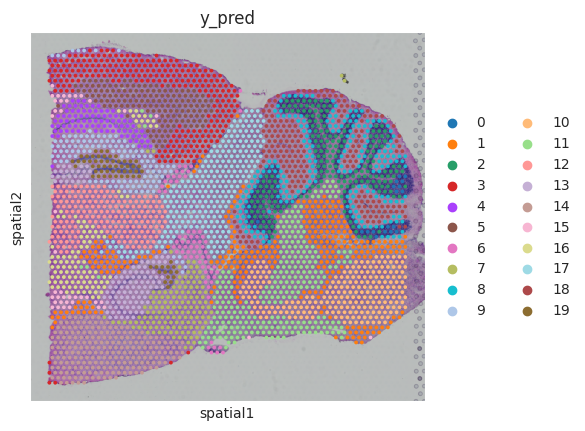

In [18]:
#visualization of spatial domains
adata.obs['y_pred']=[str(int(i)) for i in y_pred_last]
adata.obs['y_pred_init']=[str(int(i)) for i in y_pred_init]
adata.obs['x_pixel']=list(adata.obsm['spatial'][:,0])
adata.obs['y_pixel']=list(-adata.obsm['spatial'][:,1])
sc.pl.spatial(adata,color='y_pred')

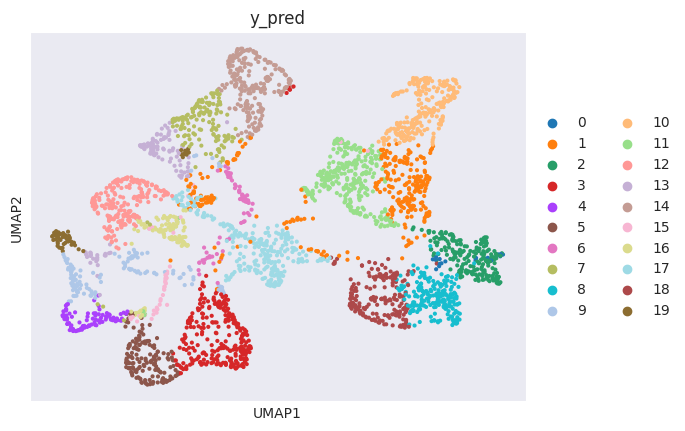

In [19]:
#UMAP visualization
adata.obsm['rep']=emb
sc.pp.neighbors(adata,use_rep='rep',random_state=0)
sc.tl.umap(adata,random_state=0)
sc.pl.umap(adata, color=['y_pred'])

In [20]:
#Moran's I statistics
stgic_moran=screen_svg('y_pred',adata) # SVG set identification for computation of moran's I score corresponding to the labels generated by DCF
print('STGIC moran statistics mean and median', np.mean(stgic_moran),np.median(stgic_moran))

Calculateing adj matrix using xy only...
Calculateing adj matrix using xy only...
Calculateing adj matrix using xy only...
Run 1: radius [1.4142135381698608, 16.124515533447266], num_nbr [1.0, 381.96091205211724]
Calculateing adj matrix using xy only...
Run 2: radius [1.4142135381698608, 8.769364535808563], num_nbr [1.0, 114.0130293159609]
Calculateing adj matrix using xy only...
Run 3: radius [1.4142135381698608, 5.091789036989212], num_nbr [1.0, 35.47557003257329]
Calculateing adj matrix using xy only...
Run 4: radius [1.4142135381698608, 3.2530012875795364], num_nbr [1.0, 20.299674267100976]
Calculateing adj matrix using xy only...
Run 5: radius [2.3336074128746986, 3.2530012875795364], num_nbr [8.794788273615636, 20.299674267100976]
Calculateing adj matrix using xy only...
Run 6: radius [2.7933043502271175, 3.2530012875795364], num_nbr [8.794788273615636, 20.299674267100976]
Calculateing adj matrix using xy only...
recommended radius =  3.023152818903327 num_nbr=12.62214983713355
r

In [21]:
# compute SC and DB score
SC= silhouette_score(emb,y_pred_last) # SC score
DB= davies_bouldin_score(emb,y_pred_last) # DB score
print('SC and DB scores by DCF clustering are %s and %s' %(SC,DB))

SC and DB scores by DCF clustering are 0.3333782 and 1.1605324596590287


In [22]:
print("+++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++")

+++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++


In [23]:
#analysis of mouse olfactory bulb stereo-seq data. Given the spots distribution on the lattice of stereo-seq and 10x Visium are different from each other and the gene capturing efficiency are also quite different, some hyper-parameter values need to be adjusted
os.chdir('/home/zhangchen/data/mouse_olfactory_bulb')
#setup of hyper-parameters which have different values from those for 10x Visium data
pretrain_lr=0.005
lr=0.001
step_con1=0.
mod3_ratio=0.9

In [24]:
#read the data with higher spatial resolution
h5ad_file='stereo_seq_bin15.h5ad'
img,coord_lattice,mask,adj,feat_agc,adata=generate_input_stereoseq(h5ad_file,n_components_agc,n_components,use_high_agc,use_high)

Run 1: l [0.01, 1000], p [0.0, 18751.435448613407]
Run 2: l [0.01, 500.005], p [0.0, 17938.471029939406]
Run 3: l [0.01, 250.0075], p [0.0, 15237.6296751907]
Run 4: l [0.01, 125.00874999999999], p [0.0, 9367.172796149855]
Run 5: l [0.01, 62.509375], p [0.0, 3731.2501083294383]
Run 6: l [0.01, 31.2596875], p [0.0, 1152.3936083494686]
Run 7: l [0.01, 15.63484375], p [0.0, 316.42640552708275]
Run 8: l [0.01, 7.822421875], p [0.0, 83.40824740951622]
Run 9: l [0.01, 3.9162109375], p [0.0, 21.2994183153984]
Run 10: l [0.01, 1.9631054687499998], p [0.0, 5.035528356386776]
Run 11: l [0.01, 0.9865527343749999], p [0.0, 0.9407651918702544]
Run 12: l [0.49827636718749996, 0.9865527343749999], p [0.08826169992354505, 0.9407651918702544]
Run 13: l [0.74241455078125, 0.9865527343749999], p [0.40543891125453535, 0.9407651918702544]
Run 14: l [0.74241455078125, 0.8644836425781249], p [0.40543891125453535, 0.6457642411725786]
Run 15: l [0.74241455078125, 0.8034490966796874], p [0.40543891125453535, 0.5

In [25]:
#AGC pre-clustering
n_clusters=9
label=None
adj_normalized = normalize_adj(adj)
adj_normalized = 1/3*torch.eye(adj_normalized.shape[0]).to(device)+2/3*adj_normalized
optimal_power,y_pred_init,kmeans_feature,pre_nmi,pre_ari=pre_cluster(adj_normalized,feat_agc,n_clusters,label,top_num=agc_dims,max_iter=30,platform='stereoseq')


In [26]:
coord_x=torch.tensor(coord_lattice[:,0]).to(torch.long).to(device)
coord_y=torch.tensor(coord_lattice[:,1]).to(torch.long).to(device)
set_seed(seed)
model3 = Dilate_MyNet5_stereoseq(img.shape[2],output_dim,nChannel,n_clusters,3,1).to(device) #instantiation of the framework without dilation
model2 = Dilate_MyNet5_stereoseq(img.shape[2],output_dim,nChannel,n_clusters,3,2).to(device) #instantiation of the framework with dilation rate 2
nmi,ari,y_pred_last,emb,final_epoch_idx=dilate2_train5_stereoseq(model3,model2,coord_x,coord_y,n_clusters,step_kl,step_con,step_con1,step_ce,label,img,mask,y_pred_init,200,400,tol=1e-3,update_interval=4,q_cut=q_cut,mod3_ratio=mod3_ratio)

delta_label  0.000787897888433659 < tol  0.001
Reach tolerance threshold. Stopping training.


In [27]:
pre_SC= silhouette_score(kmeans_feature,y_pred_init) # SC score corresponding to AGC pre-clustering
pre_DB= davies_bouldin_score(kmeans_feature,y_pred_init) # DB score corresponding to AGC pre-clustering
print('SC and DB scores by AGC pre-clustering are %s and %s' %(pre_SC,pre_DB))
SC= silhouette_score(emb,y_pred_last) # SC score
DB= davies_bouldin_score(emb,y_pred_last) # DB score
print('SC and DB scores by DCF clustering are %s and %s' %(SC,DB))

SC and DB scores by AGC pre-clustering are -0.0034680022 and 3.3409374124685134
SC and DB scores by DCF clustering are 0.5362689 and 0.7221567655358354


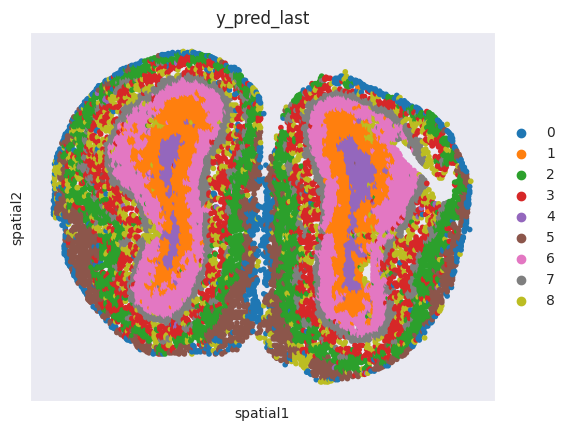

In [28]:
#visualization of spatial domains derived from DCF clustering as to the data at the higher spatial resolution
adata.obs['y_pred_init']=[str(i) for i in y_pred_init]
adata.obsm['spatial']=np.stack([adata.obsm['spatial'][:,0],-adata.obsm['spatial'][:,1]],-1)
adata.obs['x']=adata.obsm['spatial'][:,0]
adata.obs['y']=adata.obsm['spatial'][:,1]
adata.obs['y_pred_last']=[str(i) for i in y_pred_last]
sc.pl.spatial(adata,color='y_pred_last',spot_size=100000/adata.shape[0])

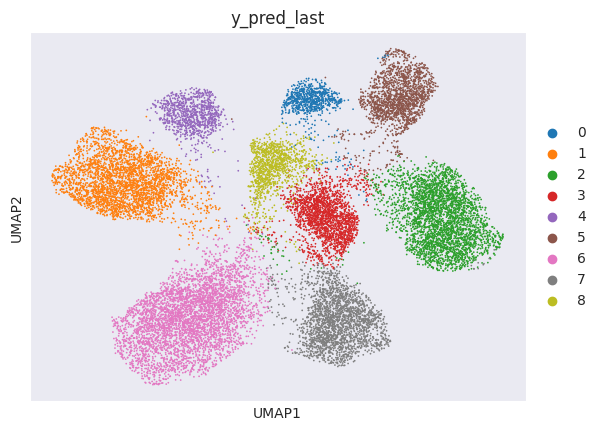

In [29]:
#UMAP visualization
adata.obsm['rep']=emb
sc.pp.neighbors(adata,use_rep='rep',random_state=0)
sc.tl.umap(adata,random_state=0)
sc.pl.umap(adata, color=['y_pred_last'])


In [30]:
print("+++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++")

+++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++


In [31]:
# analysis of the mouse olfactory bulb stereo-seq data at the lower spatial resolution
#read the data
h5ad_file='stereo_seq_bin30.h5ad'
img,coord_lattice,mask,adj,feat_agc,adata=generate_input_stereoseq(h5ad_file,n_components_agc,n_components,use_high_agc,use_high)

Run 1: l [0.01, 1000], p [0.0, 14696.390677311245]
Run 2: l [0.01, 500.005], p [0.0, 14528.836111197656]
Run 3: l [0.01, 250.0075], p [0.0, 13891.143684035389]
Run 4: l [0.01, 125.00874999999999], p [0.0, 11777.670961598269]
Run 5: l [0.01, 62.509375], p [0.0, 7211.24562392862]
Run 6: l [0.01, 31.2596875], p [0.0, 2855.7187754681536]
Run 7: l [0.01, 15.63484375], p [0.0, 875.6918392312857]
Run 8: l [0.01, 7.822421875], p [0.0, 239.36792832635723]
Run 9: l [0.01, 3.9162109375], p [0.0, 62.656042928359355]
Run 10: l [0.01, 1.9631054687499998], p [0.0, 15.757932400617914]
Run 11: l [0.01, 0.9865527343749999], p [0.0, 3.5228616067843648]
Run 12: l [0.49827636718749996, 0.9865527343749999], p [0.4186632510432948, 3.5228616067843648]
Run 13: l [0.49827636718749996, 0.74241455078125], p [0.4186632510432948, 1.6991962304145471]
Run 14: l [0.49827636718749996, 0.620345458984375], p [0.4186632510432948, 0.9816921749651897]
Run 15: l [0.49827636718749996, 0.5593109130859375], p [0.418663251043294

In [32]:
# AGC pre-clustering
n_clusters=8
label=None
adj_normalized = normalize_adj(adj)
adj_normalized = 1/3*torch.eye(adj_normalized.shape[0]).to(device)+2/3*adj_normalized
optimal_power,y_pred_init,kmeans_feature,pre_nmi,pre_ari=pre_cluster(adj_normalized,feat_agc,n_clusters,label,top_num=agc_dims,max_iter=30,platform='stereoseq')

In [33]:
coord_x=torch.tensor(coord_lattice[:,0]).to(torch.long).to(device)
coord_y=torch.tensor(coord_lattice[:,1]).to(torch.long).to(device)
set_seed(0)
model3 = Dilate_MyNet5_stereoseq(img.shape[2],output_dim,nChannel,n_clusters,3,1).to(device)
model2 = Dilate_MyNet5_stereoseq(img.shape[2],output_dim,nChannel,n_clusters,3,2).to(device)
nmi,ari,y_pred_last,emb,final_epoch_idx=dilate2_train5_stereoseq(model3,model2,coord_x,coord_y,n_clusters,step_kl,step_con,step_con1,step_ce,label,img,mask,y_pred_init,200,400,tol=1e-3,update_interval=4,q_cut=q_cut,mod3_ratio=mod3_ratio)

delta_label  0.0008811169852243459 < tol  0.001
Reach tolerance threshold. Stopping training.


In [34]:
pre_SC= silhouette_score(kmeans_feature,y_pred_init) # SC score corresponding to AGC pre-clustering
pre_DB= davies_bouldin_score(kmeans_feature,y_pred_init) # DB score corresponding to AGC pre-clustering
print('SC and DB scores by AGC pre-clustering are %s and %s' %(pre_SC,pre_DB))
SC= silhouette_score(emb,y_pred_last) # SC score
DB= davies_bouldin_score(emb,y_pred_last) # DB score
print('SC and DB scores by DCF clustering are %s and %s' %(SC,DB))

SC and DB scores by AGC pre-clustering are 0.0040560854 and 3.342166096823412
SC and DB scores by DCF clustering are 0.657165 and 0.47883275865675456


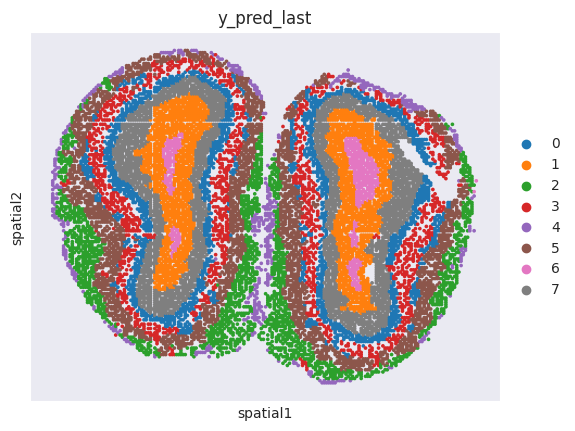

In [35]:
#visualization of spatial domains derived from DCF clustering as to the data at the higher spatial resolution
adata.obs['y_pred_init']=[str(i) for i in y_pred_init]
adata.obsm['spatial']=np.stack([adata.obsm['spatial'][:,0],-adata.obsm['spatial'][:,1]],-1)
adata.obs['x']=adata.obsm['spatial'][:,0]
adata.obs['y']=adata.obsm['spatial'][:,1]
adata.obs['y_pred_last']=[str(i) for i in y_pred_last]
sc.pl.spatial(adata,color='y_pred_last',spot_size=25000/adata.shape[0])

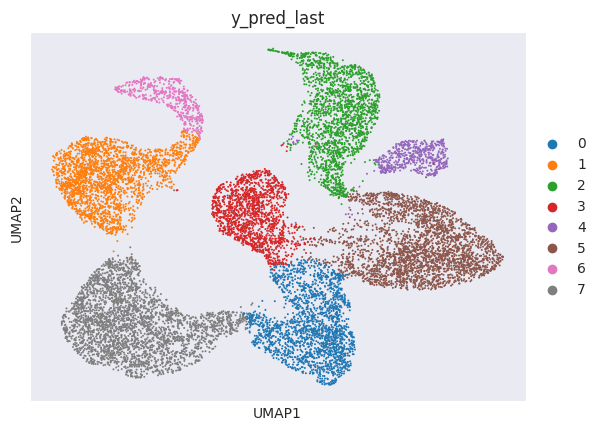

In [36]:
#UMAP visualization
adata.obsm['rep']=emb
sc.pp.neighbors(adata,use_rep='rep',random_state=0)
sc.tl.umap(adata,random_state=0)
sc.pl.umap(adata, color=['y_pred_last'])
